In [1]:
## Created by Wentinn Liao

# CS180 Project 4

In [2]:
!pip install -U setuptools numpy imageio scikit-learn scikit-image opencv-python matplotlib tensorflow

In [3]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
#@title Symlink Setup
def ptpp(PATH: str) -> str: # Converts path to python path
    return PATH.replace('\\', '')

DRIVE_PATH = '/content/gdrive/My\ Drive/CS180/HW4'
if not os.path.exists(ptpp(DRIVE_PATH)):
    %mkdir $DRIVE_PATH
SYM_PATH = '/content/HW4'
if not os.path.exists(ptpp(SYM_PATH)):
    !ln -s $DRIVE_PATH $SYM_PATH
%cd $SYM_PATH

/content/gdrive/My Drive/CS180/HW4


In [5]:
#@title Configure Jupyter Notebook
%load_ext autoreload
%autoreload 2

In [6]:
#@title Library Setup
import io
import base64
import math
import numpy as np
import scipy as sc
import skimage as sk
import skimage.io as skio
import skimage.transform as sktr
import cv2
import random
import torch
import tensorflow as tf
import json
from PIL import Image, ExifTags
from typing import *
from matplotlib import pyplot as plt
from IPython.display import HTML
from IPython import display as ipythondisplay

seed = 7
torch.manual_seed(seed)
random.seed(seed)
torch.set_default_dtype(torch.double)

In [7]:
#@title Utilities
def read_image(imname: str) -> np.ndarray:
    img = Image.open(imname)
    return sk.img_as_float(np.array(img.convert('RGBA'))) # , {ExifTags.TAGS[k]: v for k, v in img._getexif().items()}

def im_rescale(im):
    lo = np.min(im)
    hi = np.max(im)
    return (im - lo) / (hi - lo)

def im_saturate(im):
    return np.stack([im_rescale(im[:, :, c]) for c in range(im.shape[2])], axis=2)

def multiply_outer(v: np.ndarray, arr: np.ndarray, axis=None):
    if axis is None:
        axis = v.ndim
    arr_ = arr.transpose(*range(axis, arr.ndim), *range(axis))
    return (arr_ * v).transpose(*range(arr.ndim - axis, arr.ndim), *range(arr.ndim - axis))

def plot_cycle(ax, points: np.ndarray, **kwargs):
    cycled_points = np.vstack([points, points[:1]])
    ax.plot(*cycled_points.T, **kwargs)

def show_video(video_name: str):
    if os.path.exists(video_name):
        video = io.open(video_name, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

# Shoot the Pictures

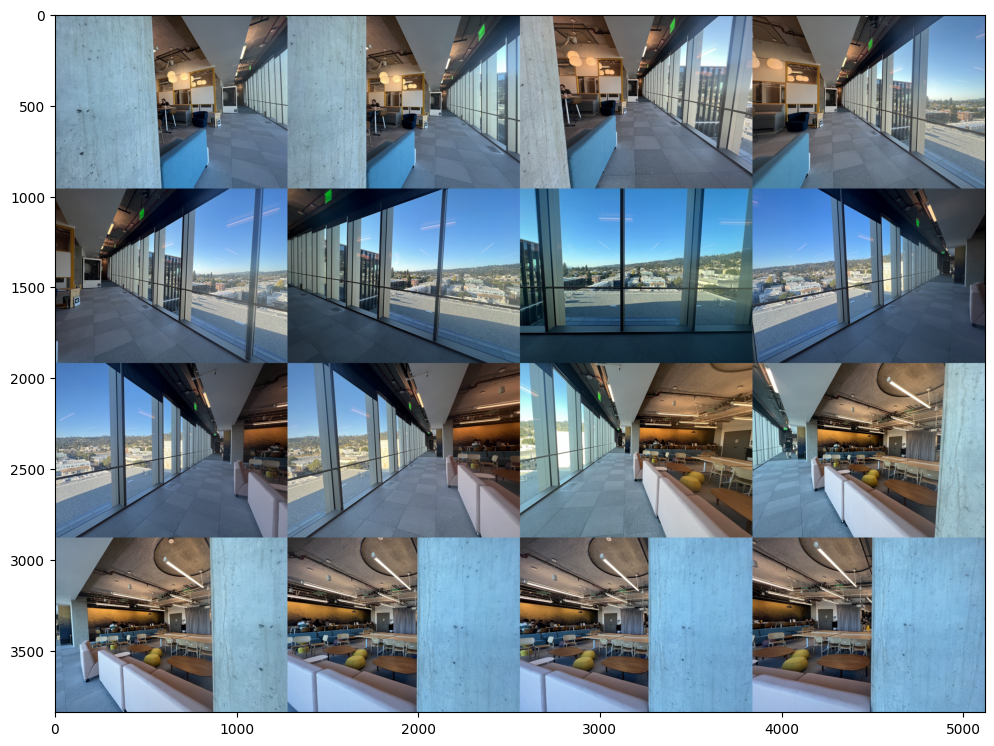

In [11]:
plt.rcParams['figure.figsize'] = (12.0, 16.0)

ims = {t: read_image(f'code/data/BWW/BWW {t}.jpg') for t in range(-6, 11)}
display_im = np.vstack([np.hstack([
    ims[4 * i + j - 6] for j in range(4)
]) for i in range(4)])
plt.imshow(display_im)
plt.show()

skio.imsave('images/image_grid.png', sk.img_as_ubyte(display_im), quality=100)

In [12]:
im0, imn1 = ims[0], ims[-1]

# Recover Homographies

In [13]:
def computeH(im1points: np.ndarray, im2points: np.ndarray):
    N = len(im1points)
    augmented_im1points = np.hstack([im1points, np.ones((N, 1))])

    X = np.zeros((2 * N, 9), dtype=float)
    X[::2, :3] = X[1::2, 3:6] = augmented_im1points
    X[::2, 6:] = -augmented_im1points * im2points[:, :1]
    X[1::2, 6:] = -augmented_im1points * im2points[:, 1:]
    X = X[:, :-1]

    y = np.concatenate(im2points)

    w = np.linalg.pinv(X) @ y
    return np.array([*w, 1]).reshape(3, 3)

In [14]:
correspondence_n1_0 = json.load(open('code/data/correspondence/BWW -1, 0.json', 'r'))
imn1points = np.array(correspondence_n1_0['im1Points'])[:, ::-1]
im0points = np.array(correspondence_n1_0['im2Points'])[:, ::-1]

H_n1_0 = computeH(imn1points, im0points)
print(H_n1_0)

[[ 5.72734930e+00  2.00805736e+00 -1.92912002e+03]
 [ 6.76838713e-01  7.96786338e+00 -3.84831577e+03]
 [ 6.55440890e-04  5.15037307e-03  1.00000000e+00]]


# Warp the Images

In [19]:
def sample_bilinear(im: np.ndarray, points: np.ndarray) -> np.ndarray:
    x, y = points.transpose(-1, *range(points.ndim - 1))
    fx, fy = np.floor(x).astype(int), np.floor(y).astype(int)
    cx, cy = fx + 1, fy + 1

    p, _p, q, _q = cx - x, x - fx, cy - y, y - fy
    cx, cy = np.clip(cx, 0, im.shape[0] - 1), np.clip(cy, 0, im.shape[1] - 1)
    return multiply_outer(p * q, im[fx, fy]) + multiply_outer(_p * q, im[cx, fy]) + multiply_outer(p * _q, im[fx, cy]) + multiply_outer(_p * _q, im[cx, cy])


def warp_image(im: np.ndarray, H: np.ndarray) -> np.ndarray:
    h, w = im.shape[:2]
    augmented_warped_corners = H @ np.array([
        [0, 0, h, h],
        [0, w, w, 0],
        [1, 1, 1, 1]
    ])
    warped_corners = (augmented_warped_corners[:2] / augmented_warped_corners[2]).T

    xy_min = np.min(warped_corners, axis=0)
    xy_max = np.max(warped_corners, axis=0)
    offset = np.floor(xy_min).astype(int)
    result_im_shape = np.ceil(xy_max).astype(int) - offset
    result_im = np.zeros((*result_im_shape, 4))

    offset_warped_corners = warped_corners - offset
    rr, cc = sk.draw.polygon(*offset_warped_corners.T)
    augmented_pixels = np.linalg.inv(H) @ np.vstack([
        rr + offset[0],
        cc + offset[1],
        np.ones_like(rr)
    ]).astype(float)
    pixels = (augmented_pixels[:2] / augmented_pixels[2]).T

    result_im[rr, cc] = sample_bilinear(im, pixels)
    return np.clip(result_im, 0, 1), offset

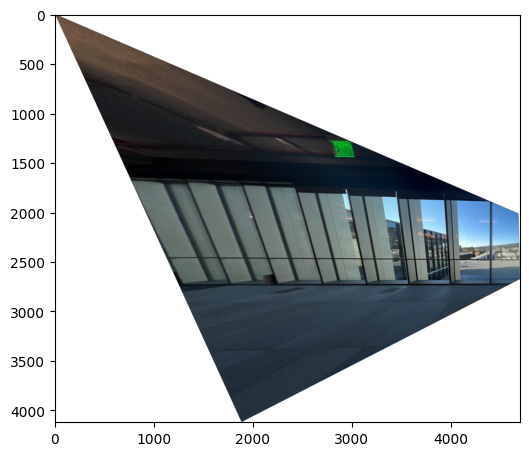

In [20]:
plt.rcParams['figure.figsize'] = (6.0, 8.0)

warped_imn1 = warp_image(imn1, H_n1_0)[0]
plt.imshow(warped_imn1)
plt.show()

skio.imsave('images/warped_imn1.png', sk.img_as_ubyte(warped_imn1), quality=100)

# Image Rectification

In [21]:
def compute_rectification_target(rectification_points: np.ndarray, center: np.ndarray=None) -> np.ndarray:
    sorted_points = np.sort(rectification_points, axis=0)
    x_min, y_min = (sorted_points[0] + sorted_points[1]) / 2
    x_max, y_max = (sorted_points[-2] + sorted_points[-1]) / 2

    rect = np.sign(rectification_points - np.mean(rectification_points, axis=0)) * np.array([x_max - x_min, y_max - y_min]) / 2
    if center is None:
        center = np.mean(rectification_points, axis=0)
    return rect + center

In [22]:
im0rectification_points = np.array(json.load(open('code/data/correspondence/BWW 0, 0.json', 'r'))['im1Points'])[:, ::-1]
im0target_points = compute_rectification_target(im0rectification_points)
print(f'Rectification points:\n{im0rectification_points}')
print(f'Target rectification points:\n{im0target_points}')

Rectification points:
[[542 141]
 [547 963]
 [184 987]
 [159 114]]
Target rectification points:
[[544.5 127.5]
 [544.5 975. ]
 [171.5 975. ]
 [171.5 127.5]]


In [23]:
H_rectification_0 = computeH(im0rectification_points, im0target_points)
print(H_rectification_0)

[[ 8.65024138e-01 -3.45767615e-02  3.28364275e+01]
 [-8.19768079e-02  8.88715014e-01  3.54541717e+01]
 [-1.47843523e-04 -5.29391980e-05  1.00000000e+00]]


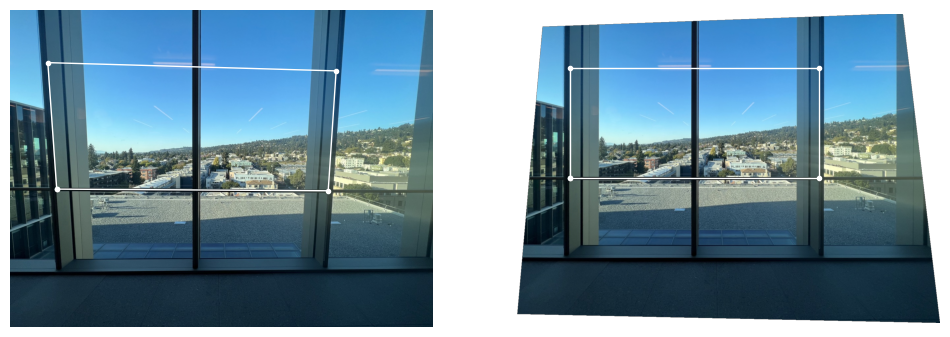

In [28]:
plt.rcParams['figure.figsize'] = (12.0, 16.0)

fig, axs = plt.subplots(1, 2)
axs[0].axis('off')
axs[0].imshow(im0)
plot_cycle(axs[0], im0rectification_points[:, ::-1], linewidth=1, marker='.', color='white')

rectified_im0, offset_im0 = warp_image(im0, H_rectification_0)
axs[1].axis('off')
axs[1].imshow(rectified_im0)
plot_cycle(axs[1], (im0target_points - offset_im0)[:, ::-1], linewidth=1, marker='.', color='white')
plt.show()


fig.savefig(
    'images/unrectified_im0',
    bbox_inches=axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted()),
    pad_inches=0.
)
fig.savefig(
    'images/rectified_im0',
    bbox_inches=axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted()),
    pad_inches=0.
)

# Mosaic Image Blending

In [29]:
def buffer_images(ims: List[np.ndarray], offsets: List[np.ndarray]):
    C = ims[0].shape[-1]
    xy_mins = offsets = np.array(offsets)
    xy_maxs = np.array([im.shape[:2] for im in ims]) + offsets
    xy_min = np.min(xy_mins, axis=0)
    xy_max = np.max(xy_maxs, axis=0)

    result_im_shape = xy_max - xy_min
    result = []
    for i in range(len(ims)):
        result_im = np.zeros((*result_im_shape, C), dtype=float)
        result_im[xy_mins[i, 0] - xy_min[0]:xy_maxs[i, 0] - xy_min[0], xy_mins[i, 1] - xy_min[1]:xy_maxs[i, 1] - xy_min[1]] = ims[i]
        result.append(result_im)
    return result

In [30]:
H_rectification_n1 = H_rectification_0 @ H_n1_0
rectified_imn1, offset_imn1 = warp_image(imn1, H_rectification_n1)
buffered_ims = buffer_images([rectified_im0, rectified_imn1], [offset_im0, offset_imn1])

In [31]:
#@title Image Blending
def gaussian_stack(im, depth=4, sigma=3):
    gaussian_stack = [im]
    for _ in range(depth):
        k = int(math.ceil(3 * sigma))
        G = ((G := cv2.getGaussianKernel(2 * k + 1, sigma)) @ G.T)[:, :, None]

        gaussian_stack.append(sc.signal.convolve(gaussian_stack[-1], G, mode='same'))
        sigma *= 2
    return gaussian_stack

def gaussian_and_laplacian_stack(im, depth=4, sigma=3):
    gaussian_stack, laplacian_stack = [im], []
    for _ in range(depth + 1):
        k = int(math.ceil(3 * sigma))
        G = ((G := cv2.getGaussianKernel(2 * k + 1, sigma)) @ G.T)[:, :, None]

        gaussian_stack.append(sc.signal.convolve(gaussian_stack[-1], G, mode='same'))
        laplacian_stack.append(gaussian_stack[-2] - gaussian_stack[-1])

        sigma *= 2
    gaussian_stack.pop()
    laplacian_stack[-1] = gaussian_stack[-1]
    return gaussian_stack, laplacian_stack

def blend(im1, im2, depth=4, sigma=3):
    mask = sc.ndimage.distance_transform_edt(im1[:, :, -1:]) > sc.ndimage.distance_transform_edt(im2[:, :, -1:])
    mask_gaussian_stack = gaussian_stack(mask, depth=depth)

    im1_gaussian_stack, im1_laplacian_stack = gaussian_and_laplacian_stack(im1, depth=depth)
    im2_gaussian_stack, im2_laplacian_stack = gaussian_and_laplacian_stack(im2, depth=depth)

    blend_stack = []
    for d in range(depth + 1):
        l1, l2 = im1_laplacian_stack[d], im2_laplacian_stack[d]
        mask = mask_gaussian_stack[d]

        masked_l1, masked_l2 = mask * l1, (1 - mask) * l2
        blend_stack.append(blend := masked_l1 + masked_l2)

    blended_im = np.clip(np.sum(blend_stack, axis=0), 0, 1)
    return blended_im

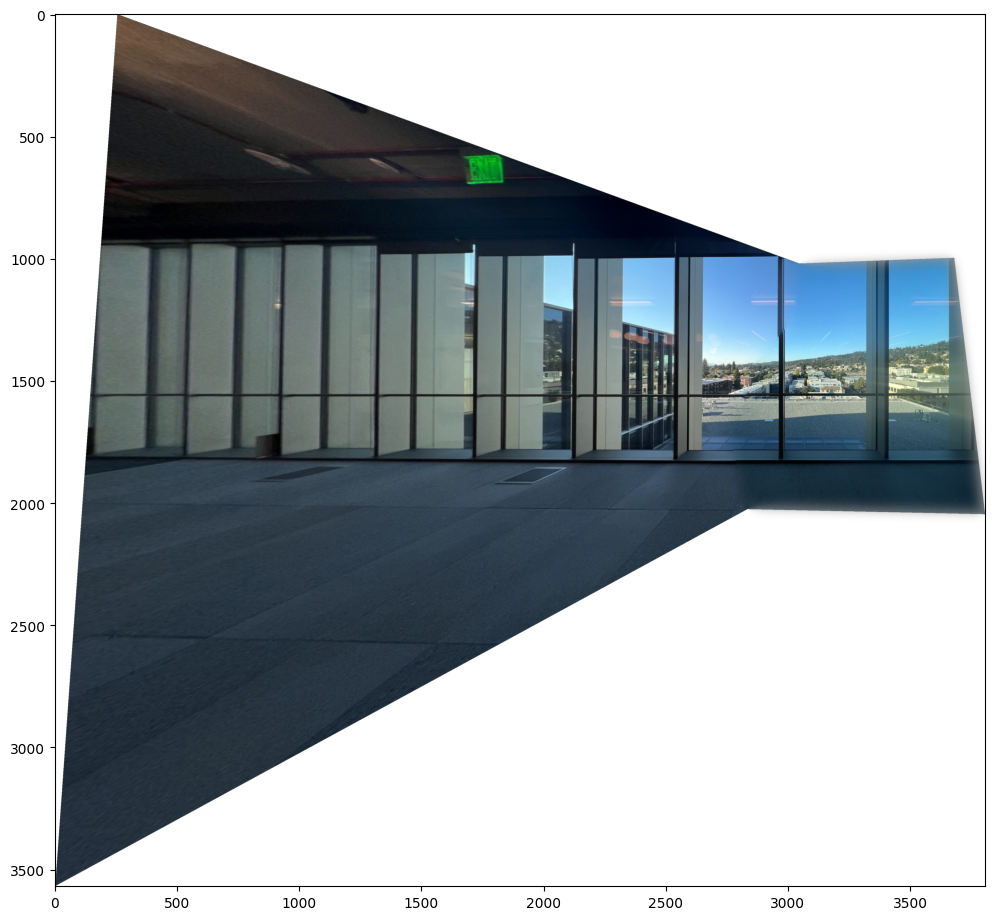

In [34]:
blended_im = blend(*buffered_ims)
plt.imshow(blended_im)
plt.show()

skio.imsave('images/blended_im0_n1.png', sk.img_as_ubyte(blended_im), quality=100)